<font color='blue' size="+3">Explainable Machine Learning Model for Malaria prediction with improved accuracy</font>


In [ ]:
!pip install catboost
!pip install lime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import missingno as msno
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    cohen_kappa_score, f1_score, roc_curve, roc_auc_score, auc,
    accuracy_score, classification_report, confusion_matrix,
    matthews_corrcoef, balanced_accuracy_score, precision_score,
    recall_score
)
from sklearn.ensemble import (
    RandomForestClassifier, BaggingClassifier, AdaBoostClassifier,
    GradientBoostingClassifier, ExtraTreesClassifier
)
from sklearn.tree import DecisionTreeClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from tqdm import tqdm

import lime
from lime.lime_tabular import LimeTabularExplainer
from lime import lime_tabular


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=db4f7451ccd2a930ca7b15213120a9ae2657616bf1a63ffe538d4de8209dee68
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
#   first read the data file
df= pd.read_csv('/content/Malaria-Data.csv')

# Exploratory Data Analysis

We need to explore/clean/filter it before processing it for machine learning It involves adding/deleting few columns or rows, joining some other data, and handling qualitative variables like dates.

In [ ]:
df.shape

(337, 18)

In [ ]:
df.head()

age  sex  fever  cold  rigor  fatigue  headace  bitter_tongue  vomitting  \
0    3    1      1     1      0        1        1              1          0   
1    3    0      1     1      1        1        1              1          0   
2    3    0      1     1      1        1        1              0          0   
3    4    1      1     1      0        1        0              0          0   
4    4    0      1     1      1        0        1              0          0   

   diarrhea  Convulsion  Anemia  jundice  cocacola_urine  hypoglycemia  \
0         1           1       0        1               1             1   
1         1           0       0        0               1             1   
2         1           1       0        0               1             1   
3         0           0       0        1               0             1   
4         0           1       0        1               1             1   

   prostraction  hyperpyrexia  severe_maleria  
0             0             0               0  
1             0             0               0  
2             0             0               1  
3             0             1               0  
4             0             0               0

In [ ]:
df.describe()

age         sex       fever        cold       rigor     fatigue  \
count  337.000000  337.000000  337.000000  337.000000  337.000000  337.000000   
mean    30.347181    0.534125    0.750742    0.566766    0.341246    0.483680   
std     14.720853    0.499576    0.433227    0.496259    0.474833    0.500477   
min      3.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%     19.000000    0.000000    1.000000    0.000000    0.000000    0.000000   
50%     29.000000    1.000000    1.000000    1.000000    0.000000    0.000000   
75%     38.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max     77.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

          headace  bitter_tongue   vomitting    diarrhea  Convulsion  \
count  337.000000     337.000000  337.000000  337.000000  337.000000   
mean     0.700297       0.403561    0.074184    0.338279    0.344214   
std      0.458809       0.491341    0.262460    0.473828    0.475818   
min      0.000000       0.000000    0.000000    0.000000    0.000000   
25%      0.000000       0.000000    0.000000    0.000000    0.000000   
50%      1.000000       0.000000    0.000000    0.000000    0.000000   
75%      1.000000       1.000000    0.000000    1.000000    1.000000   
max      1.000000       1.000000    1.000000    1.000000    1.000000   

           Anemia     jundice  cocacola_urine  hypoglycemia  prostraction  \
count  337.000000  337.000000      337.000000    337.000000    337.000000   
mean     0.350148    0.658754        0.540059      0.857567      0.219585   
std      0.477726    0.474833        0.499134      0.350014      0.414581   
min      0.000000    0.000000        0.000000      0.000000      0.000000   
25%      0.000000    0.000000        0.000000      1.000000      0.000000   
50%      0.000000    1.000000        1.000000      1.000000      0.000000   
75%      1.000000    1.000000        1.000000      1.000000      0.000000   
max      1.000000    1.000000        1.000000      1.000000      1.000000   

       hyperpyrexia  severe_maleria  
count    337.000000      337.000000  
mean       0.139466        0.344214  
std        0.346947        0.475818  
min        0.000000        0.000000  
25%        0.000000        0.000000  
50%        0.000000        0.000000  
75%        0.000000        1.000000  
max        1.000000        1.000000

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337 entries, 0 to 336
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             337 non-null    int64
 1   sex             337 non-null    int64
 2   fever           337 non-null    int64
 3   cold            337 non-null    int64
 4   rigor           337 non-null    int64
 5   fatigue         337 non-null    int64
 6   headace         337 non-null    int64
 7   bitter_tongue   337 non-null    int64
 8   vomitting       337 non-null    int64
 9   diarrhea        337 non-null    int64
 10  Convulsion      337 non-null    int64
 11  Anemia          337 non-null    int64
 12  jundice         337 non-null    int64
 13  cocacola_urine  337 non-null    int64
 14  hypoglycemia    337 non-null    int64
 15  prostraction    337 non-null    int64
 16  hyperpyrexia    337 non-null    int64
 17  severe_maleria  337 non-null    int64
dtypes: int64(18)
memory usage: 47.

In [ ]:
df.columns

Index(['age', 'sex', 'fever', 'cold', 'rigor', 'fatigue', 'headace',
       'bitter_tongue', 'vomitting', 'diarrhea', 'Convulsion', 'Anemia',
       'jundice', 'cocacola_urine', 'hypoglycemia', 'prostraction',
       'hyperpyrexia', 'severe_maleria'],
      dtype='object')

In [ ]:
df.isnull().sum()

age               0
sex               0
fever             0
cold              0
rigor             0
fatigue           0
headace           0
bitter_tongue     0
vomitting         0
diarrhea          0
Convulsion        0
Anemia            0
jundice           0
cocacola_urine    0
hypoglycemia      0
prostraction      0
hyperpyrexia      0
severe_maleria    0
dtype: int64

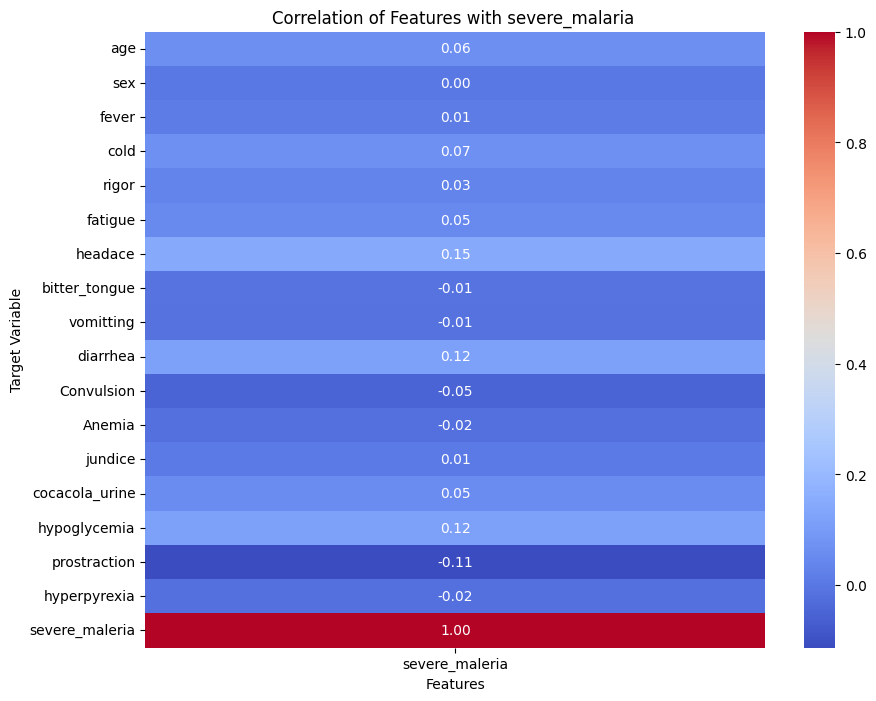

In [ ]:



# Compute Pearson correlation coefficients
corr_matrix = df.corr()

# Extract correlations of features with the target variable
target_corr = corr_matrix['severe_maleria']

# Plot heatmap of correlations
plt.figure(figsize=(10, 8))
sns.heatmap(target_corr.to_frame(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation of Features with severe_malaria ')
plt.xlabel('Features')
plt.ylabel('Target Variable')
plt.show()


#Feature Selection

In [ ]:
X = df.drop(columns=['severe_maleria'])  # Features
y = df['severe_maleria']  # Target variable

# Calculate the correlation coefficients between features and the target variable
correlation_scores = X.corrwith(y)

# Select features with correlation coefficient above a threshold (e.g., 0.01)
selected_features = correlation_scores[abs(correlation_scores) > 0.01].index.tolist()
# Include the target variable in the selected features
selected_features.append('severe_maleria')

# Create a new DataFrame with selected features and target variable
df_selected = df[selected_features]
# Print the selected features
print("Selected features:", selected_features)


Selected features: ['age', 'fever', 'cold', 'rigor', 'fatigue', 'headace', 'bitter_tongue', 'vomitting', 'diarrhea', 'Convulsion', 'Anemia', 'cocacola_urine', 'hypoglycemia', 'prostraction', 'hyperpyrexia', 'severe_maleria']


In [ ]:
df_copy = df_selected.copy()

In [ ]:
correlation_scores

age               0.061919
sex               0.000520
fever             0.013195
cold              0.066237
rigor             0.031818
fatigue           0.048656
headace           0.146766
bitter_tongue    -0.010350
vomitting        -0.014426
diarrhea          0.115634
Convulsion       -0.051646
Anemia           -0.021174
jundice           0.007700
cocacola_urine    0.054551
hypoglycemia      0.116556
prostraction     -0.112729
hyperpyrexia     -0.021238
dtype: float64

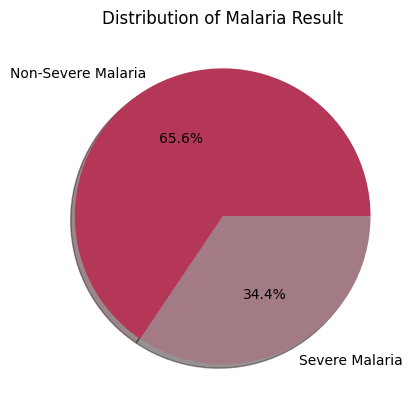

In [ ]:
# Create a pie chart of the distribution of Malaria result

# Define labels and colors
custom_colors = ['#B43757', '#a37b85']
labels = ['Non-Severe Malaria', 'Severe Malaria']

#get the counts
result_counts = df_copy['severe_maleria'].value_counts()

# Create pie chart
plt.pie(result_counts, labels=labels, autopct='%1.1f%%', colors=custom_colors, shadow=True)
plt.title('Distribution of Malaria Result')
plt.show()


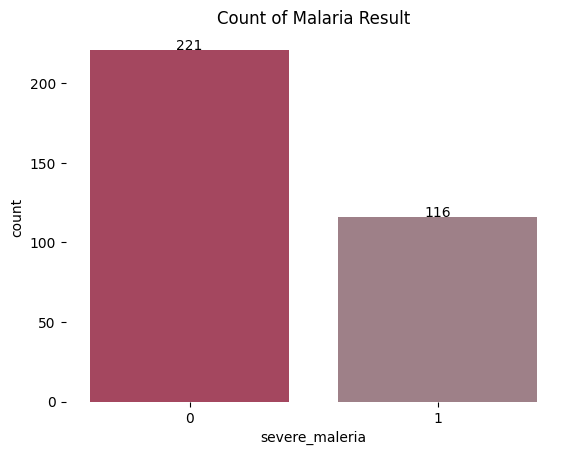

In [ ]:
# Create a count plot of the Malaria result

ax = sns.countplot(x='severe_maleria', data=df_copy, palette=custom_colors)
plt.title('Count of Malaria Result')

# Add labels to the bars
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2, height + 0.1, '{:.0f}'.format(height), ha='center')

# Remove spines
sns.despine(left=True, bottom=True)

plt.show()


 We can see clearly that we have an imbalanced dataset which indicates that 65.6% of the population don't have malaria and 34.4% has malaria. we need to address the class imbalance in our data before building a predictive model

Imbalanced classes can cause issues in machine learning models, as the model may be biased towards the majority class and may not perform well on the minority class.

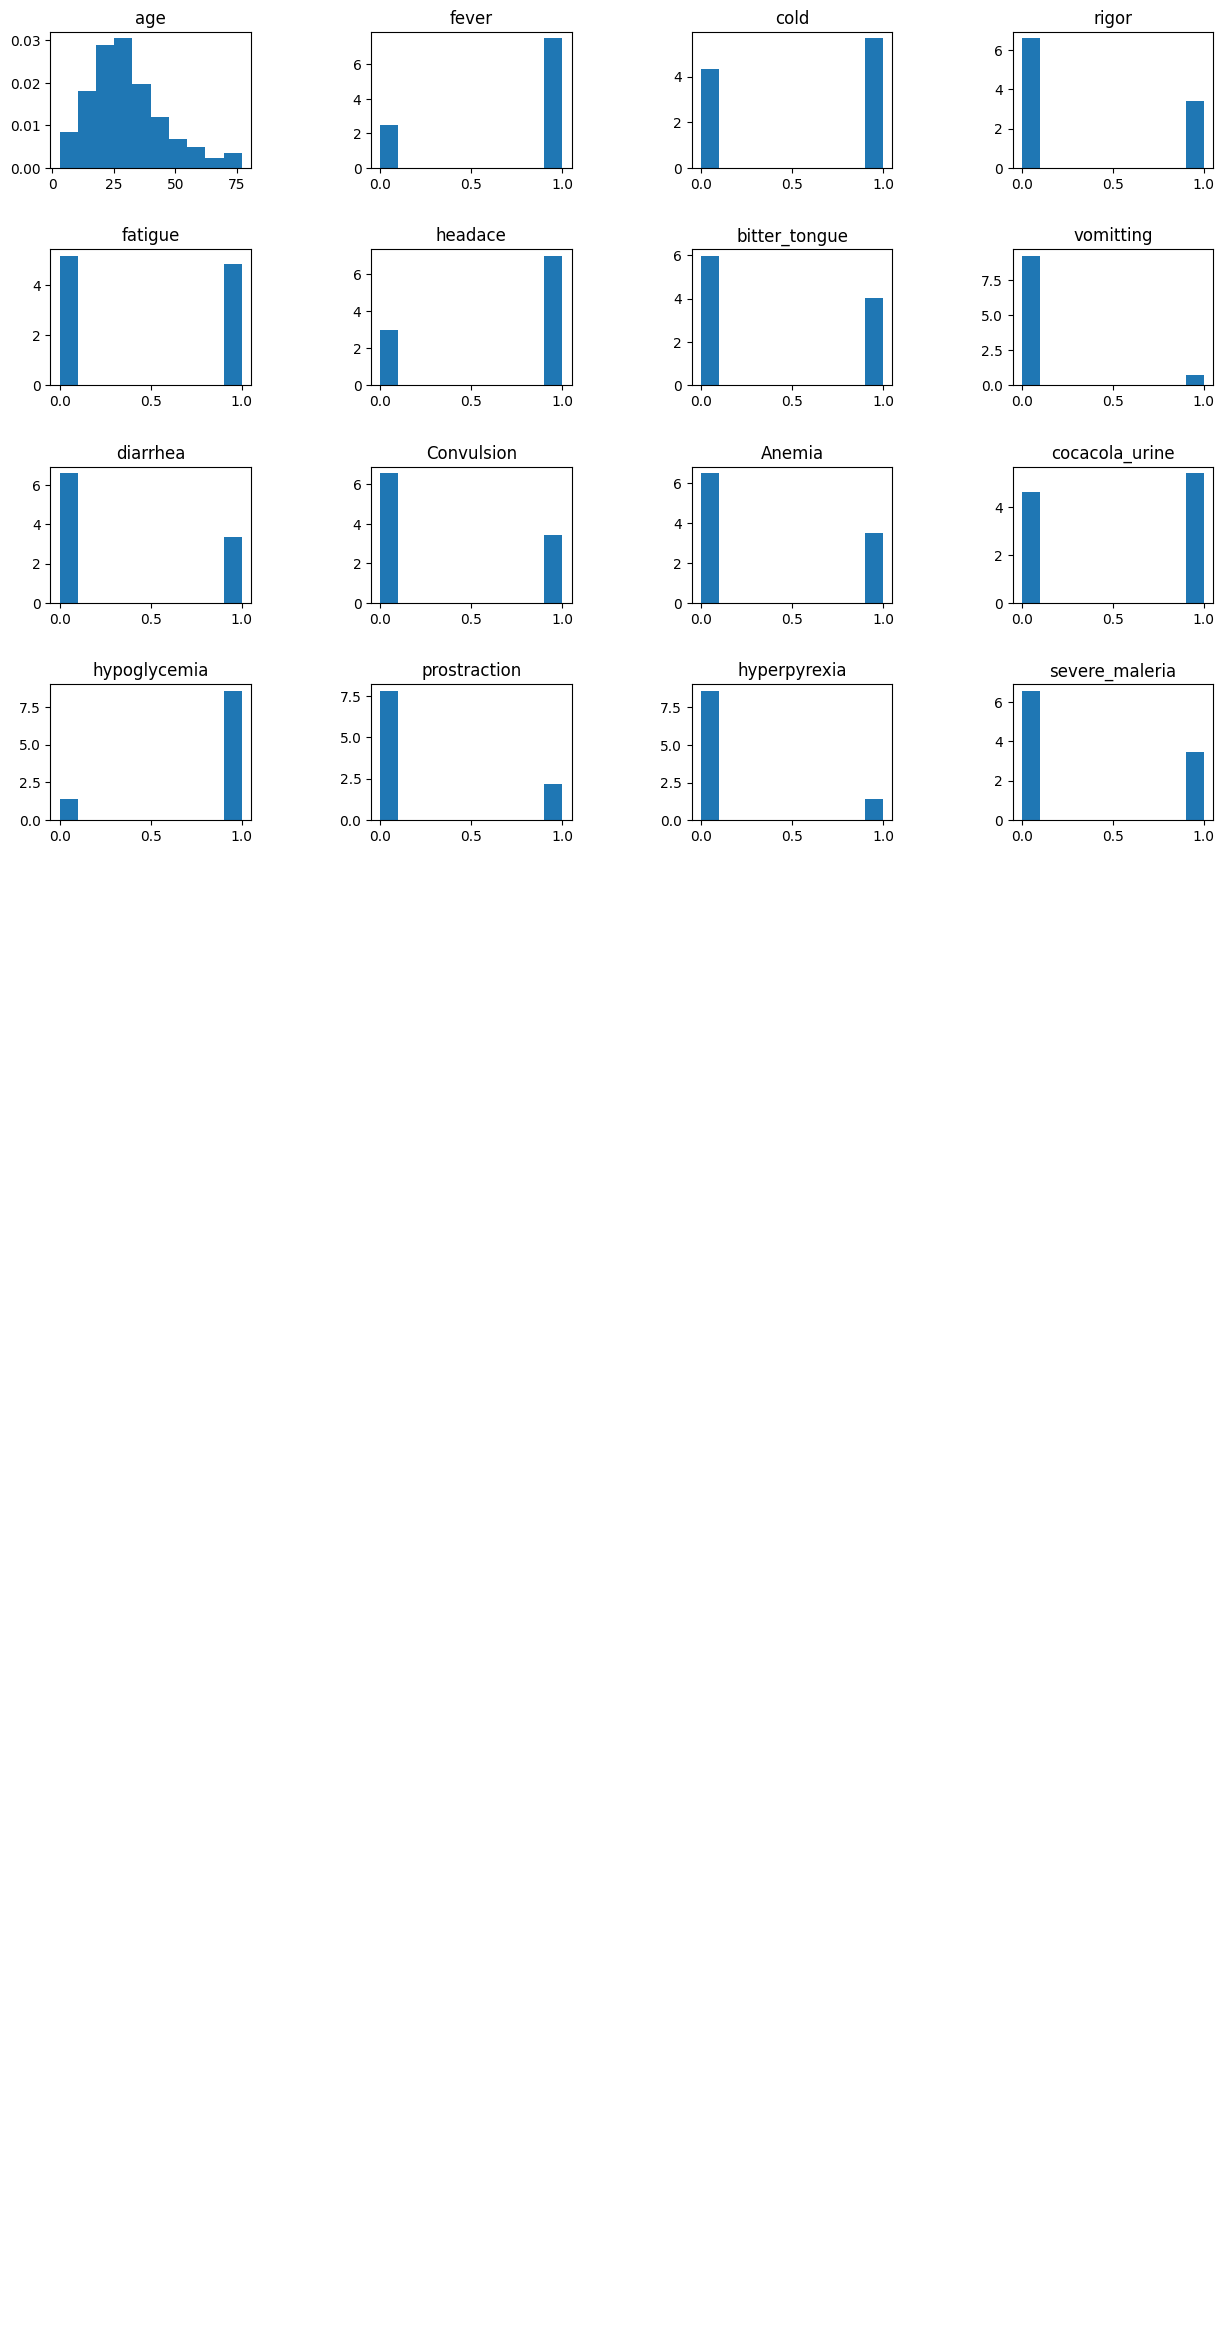

In [ ]:
# Create the figure and subplots
fig, axs = plt.subplots(11, 4, figsize=(15, 30))

# Flatten the axs array to make it easier to iterate through
axs = axs.flatten()

# Loop through each feature and plot a histogram in a separate subplot
for i, col in enumerate(df_copy.columns):
    axs[i].hist(df_copy[col], density = True, bins=10)
    axs[i].set_title(col)

# Hide any unused subplots
for i in range(len(df_copy.columns), 11 * 4):
    axs[i].axis('off')

# Add a main title and adjust the spacing between subplots
#plt.suptitle('Histograms for Multiple Features')
plt.subplots_adjust(hspace=0.6, wspace=0.6)
#fig.suptitle("Histogram for the features", fontsize = 30)

# Show the plot
plt.show()

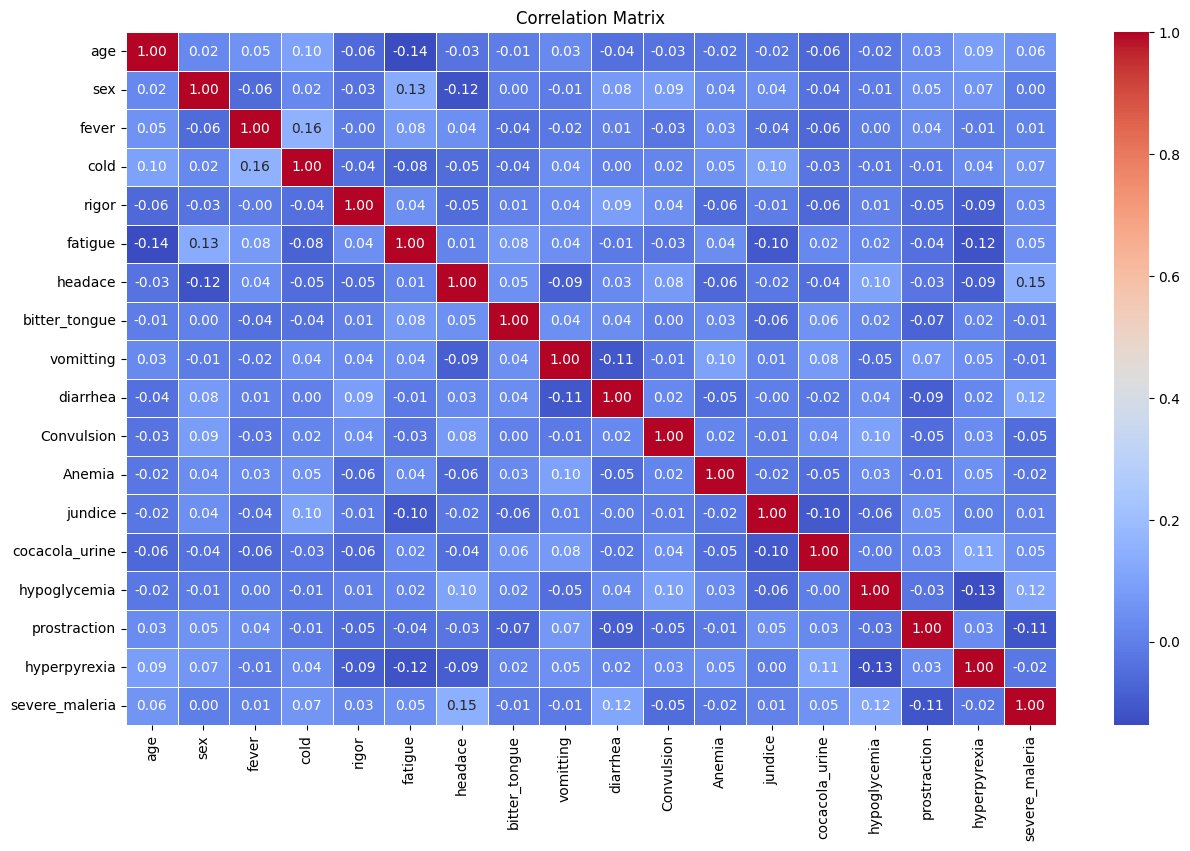

In [ ]:
# Create the correlation matrix
correlation_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 9))

# Plot the correlation matrix
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

# Add title
plt.title('Correlation Matrix')

# Show plot
plt.show()


From the heatmap we don't  have highly correlated features

In [ ]:
# Calculate the correlation matrix
corr_matrix = df_copy.corr().unstack().sort_values().drop_duplicates()
# Display the correlation matrix
print(corr_matrix)

fatigue         age              -0.136779
hypoglycemia    hyperpyrexia     -0.130032
hyperpyrexia    fatigue          -0.115403
severe_maleria  prostraction     -0.112729
vomitting       diarrhea         -0.106664
                                    ...   
diarrhea        severe_maleria    0.115634
severe_maleria  hypoglycemia      0.116556
headace         severe_maleria    0.146766
cold            fever             0.160696
age             age               1.000000
Length: 121, dtype: float64


# Splitting data into Training and Testing samples

In [ ]:
X = df_copy.drop(["severe_maleria"], axis=1) #independent
y = df_copy.severe_maleria #dependent

In [ ]:
# Split the data into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, shuffle=True, random_state=101)

In [ ]:
# Quick sanity check with the shapes of Training and testing datasets
print("X_train - ",X_train.shape)
print("y_train - ",y_train.shape)
print("X_test - ",X_test.shape)
print("y_test - ",y_test.shape)

X_train -  (235, 15)
y_train -  (235,)
X_test -  (102, 15)
y_test -  (102,)


# models used
We will train five types of classifiers and decide which classifier will be more effective in detecting malaria condition.

We will use:
**Classification Models**

1. Random Forest
2. Adaptive Boosting( AdaBoost)
3. Gradient Boost
4. XGBoost
5. CatBoost

# Model Building
We are aware that our dataset is highly imbalanced, however, we check the performance of imbalance dataset first and later we implement some techniques to balance the dataset and again check the performance of balanced dataset. Finally, we will compare each regression models performance.

In [ ]:
scaler=StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
X_test

array([[-0.01637176,  0.5920935 ,  0.84577093, ..., -2.35112266,
        -0.52647309, -0.38982148],
       [-1.02883573,  0.5920935 , -1.18235324, ...,  0.42532872,
        -0.52647309, -0.38982148],
       [ 0.45611143,  0.5920935 ,  0.84577093, ...,  0.42532872,
         1.89943232, -0.38982148],
       ...,
       [ 1.67106819, -1.68892244,  0.84577093, ...,  0.42532872,
        -0.52647309, -0.38982148],
       [ 1.4685754 ,  0.5920935 , -1.18235324, ...,  0.42532872,
        -0.52647309, -0.38982148],
       [ 0.32111623,  0.5920935 , -1.18235324, ...,  0.42532872,
         1.89943232, -0.38982148]])

In [ ]:
Store_models = [
    ("Random Forest", RandomForestClassifier(random_state=123)),
    ("AdaBoost", AdaBoostClassifier(random_state=123)),
    ("Gradient Boost", GradientBoostingClassifier(random_state=123)),
    ("XGBoost", XGBClassifier(random_state=123)),
    ("CatBoost", CatBoostClassifier(random_state=123, silent=True)),
]


In [ ]:
# Initialize an empty list to store results
results_list = []

for clf_name, clf in tqdm(Store_models):
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)

    score = accuracy_score(y_test, predictions)
    ypred_prob = clf.predict_proba(X_test)[:, 1]
    rocAuc_score = roc_auc_score(y_test, ypred_prob)
    mcc = matthews_corrcoef(y_test, predictions)
    bal_acc = balanced_accuracy_score(y_test, predictions)
    kappa = cohen_kappa_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)

    # Calculate F1 score
    f1 = f1_score(y_test, predictions)

    # Store results in a dictionary
    results_dict = {"Model": clf_name, "Accuracy Score": score, 'Roc_Auc_score':rocAuc_score, "MCC":mcc,
               "Balanced_Acc":bal_acc, "Cohen_Kappa": kappa, "Precision": precision,
               "Recall":recall, "F1 Score": f1}

    # Append the dictionary to the list
    results_list.append(results_dict)

# Convert the list of dictionaries to a DataFrame
Store_model_results = pd.DataFrame(results_list)


100%|██████████| 5/5 [00:02<00:00,  1.89it/s]


In [ ]:
Store_model_results.sort_values(by="MCC", ascending=False)

Model  Accuracy Score  Roc_Auc_score       MCC  Balanced_Acc  \
0   Random Forest        0.647059       0.579834  0.139679      0.548441   
4        CatBoost        0.637255       0.592100  0.132150      0.552391   
2  Gradient Boost        0.627451       0.566736  0.100311      0.538877   
1        AdaBoost        0.617647       0.597505  0.089627      0.537006   
3         XGBoost        0.588235       0.561331  0.077801      0.537214   

   Cohen_Kappa  Precision    Recall  F1 Score  
0     0.112615   0.538462  0.189189  0.280000  
4     0.117812   0.500000  0.243243  0.327273  
2     0.088000   0.470588  0.216216  0.296296  
1     0.082141   0.450000  0.243243  0.315789  
3     0.077122   0.419355  0.351351  0.382353

-Random Forest: Random Forest achieves the highest Accuracy Score of 0.6471 among the  models. However, its MCC (Matthews Correlation Coefficient) is moderate at 0.155, and its ROC AUC Score is 0.5869. The model shows a Precision of 0.5294 and a Recall of 0.2432.

-XGBoost: XGBoost demonstrates an Accuracy Score of 0.6176 and a slightly higher ROC AUC Score of 0.5904 compared to Random Forest. However, its MCC is lower at 0.1202. The Precision of XGBoost is 0.4615, and its Recall is relatively higher at 0.3243.

-Gradient Boost: Gradient Boost achieves an Accuracy Score of 0.6078 and a slightly higher ROC AUC Score of 0.6000 compared to XGBoost. However, its MCC is lower at 0.0916. The Precision of Gradient Boost is 0.4400, and its Recall is 0.2973.

-AdaBoost: AdaBoost also achieves an Accuracy Score of 0.6176, similar to XGBoost, and its ROC AUC Score is 0.5975. However, its MCC is slightly lower at 0.0896. The Precision of AdaBoost is 0.4500, and its Recall is 0.2432.

-CatBoost: CatBoost achieves an Accuracy Score of 0.6078, with a slightly higher ROC AUC Score of 0.6087 compared to other models. However, its MCC is the lowest among the listed models at 0.0580. The Precision of CatBoost is 0.4211, and its Recall is 0.2162.

#Confusion Matrix

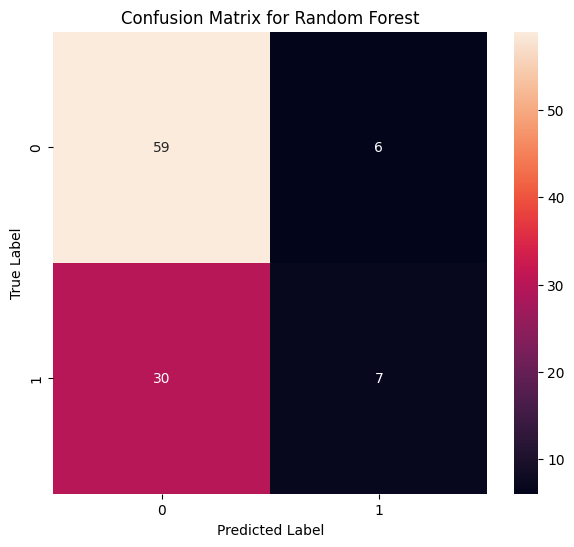

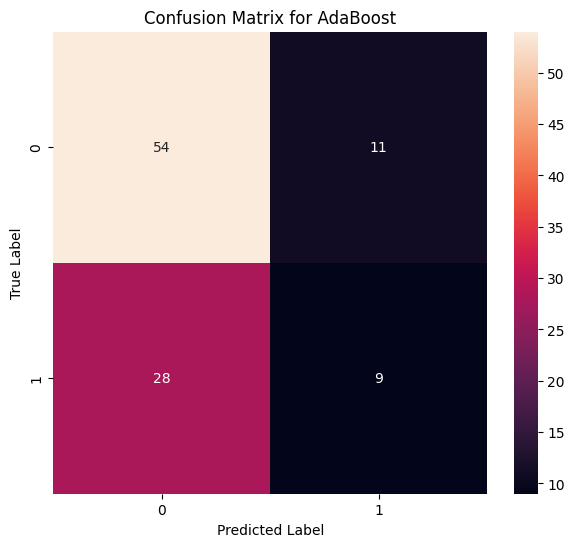

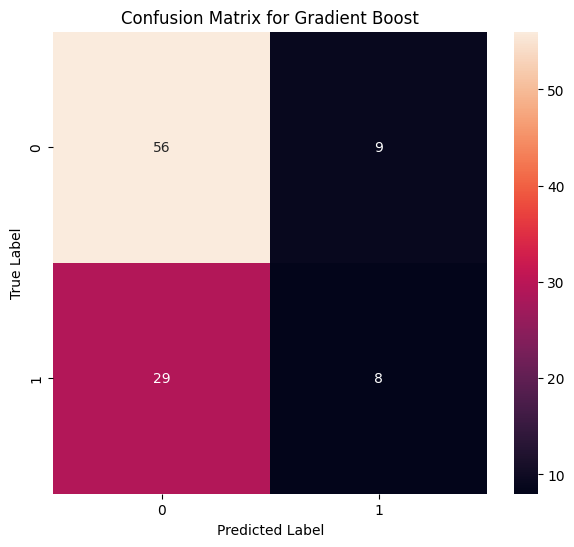

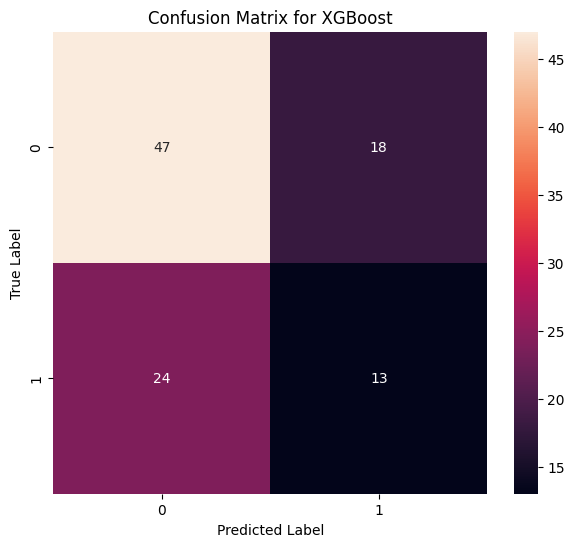

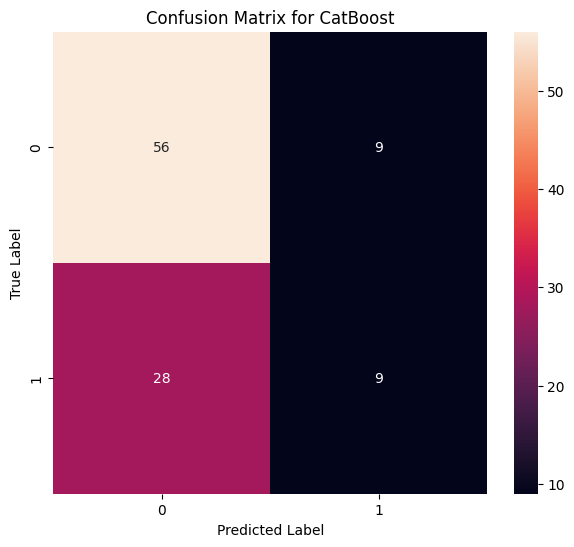

In [ ]:
for model_name, model in Store_models:
    # Fit the model with your training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, predictions)

    # Plot the confusion matrix using seaborn's heatmap
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


In [ ]:
y_test_series = y_test.squeeze()  # Convert DataFrame to Series
# Get the value counts of the Series
value_counts = y_test_series.value_counts()
print(value_counts)


severe_maleria
0    65
1    37
Name: count, dtype: int64


#ROC Curve

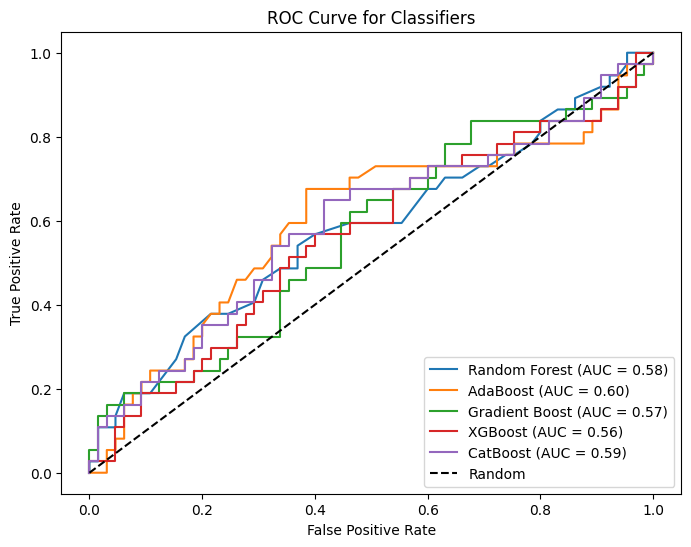

In [ ]:
# Plot ROC curves for each classifier
plt.figure(figsize=(8, 6))

for clf_name, clf in Store_models:
    clf.fit(X_train, y_train)
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classifiers')
plt.legend(loc='lower right')
plt.show()


# Class Imbalance

As found in EDA, the response variable anemia_bin have unequal data.


To tackle the imbalance, we will be focuing on



## Random Oversampling
Random oversampling duplicates examples from the minority class in the training dataset and can result in overfitting for some models.



# Oversampling

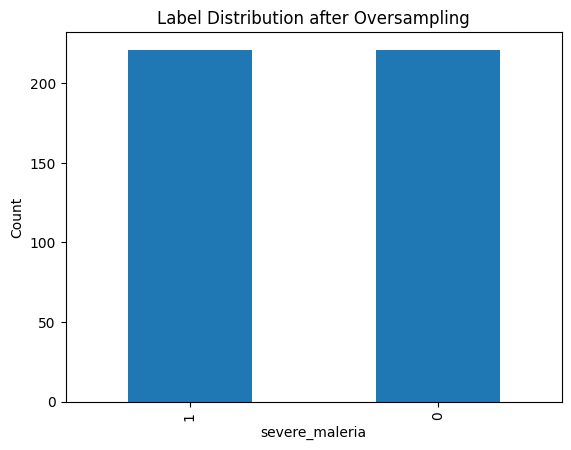

In [ ]:
# over sampling of the dataset to get a balanced dataset
class_0 = df_copy[df_copy['severe_maleria'] == 0]
class_1 = df_copy[df_copy['severe_maleria'] == 1]

# over sampling of the minority class 1
class_1_over = class_1.sample(len(class_0), replace=True)

# Creating a new dataframe with over sampled class 1 df and class 0 df
df_new = pd.concat([class_1_over, class_0], axis=0)

# plotting the new label distribution
df_new['severe_maleria'].value_counts().plot(kind='bar', title='Label Distribution after Oversampling')
plt.ylabel('Count')
plt.show()

In [ ]:
X = df_new.drop('severe_maleria', axis = 1) # features
y = df_new[['severe_maleria']] # labels

# splitting the features and labels into train and test with test size = 20% and train size = 80%
X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.30, random_state=101)

In [ ]:
Store_models_over = [
    ("Random Forest", RandomForestClassifier(random_state=123,)),
    ("AdaBoost", AdaBoostClassifier(random_state=123)),
    ("Gradient Boost", GradientBoostingClassifier(random_state=123)),
    ("XGBoost", XGBClassifier(random_state=123)),
    ("CatBoost", CatBoostClassifier(random_state=123, silent=True)),
]

In [ ]:

Store_model_results_over = pd.DataFrame(columns=["Model", "Accuracy Score"])

In [ ]:
# Initialize an empty list to store results
results_list = []

for clf_name, clf in tqdm(Store_models_over):
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)

    score = accuracy_score(y_test, predictions)
    ypred_prob = clf.predict_proba(X_test)[:, 1]
    rocAuc_score = roc_auc_score(y_test, ypred_prob)
    mcc = matthews_corrcoef(y_test, predictions)
    bal_acc = balanced_accuracy_score(y_test, predictions)
    acc = accuracy_score(y_test, predictions)
    kappa = cohen_kappa_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)

    # Store results in a dictionary
    results_dict = {"Model": clf_name, "Accuracy Score": score, 'Roc_Auc_score':rocAuc_score, "MCC":mcc,
               "Balanced_Acc":bal_acc, "Cohen_Kappa": kappa, "Precision": precision,
               "Recall":recall}

    # Append the dictionary to the list
    results_list.append(results_dict)

# Convert the list of dictionaries to a DataFrame
Store_model_results_over = pd.DataFrame(results_list)


100%|██████████| 5/5 [00:04<00:00,  1.19it/s]


In [ ]:
Store_model_results_over.sort_values(by="Precision", ascending=False)

Model  Accuracy Score  Roc_Auc_score       MCC  Balanced_Acc  \
0   Random Forest        0.781955       0.869832  0.563819      0.782485   
4        CatBoost        0.774436       0.844389  0.546797      0.773398   
3         XGBoost        0.774436       0.813494  0.550520      0.767265   
2  Gradient Boost        0.691729       0.757156  0.378451      0.685711   
1        AdaBoost        0.639098       0.660495  0.274875      0.637438   

   Cohen_Kappa  Precision    Recall  
0     0.563243   0.808824  0.774648  
4     0.546797   0.788732  0.788732  
3     0.541168   0.746988  0.873239  
2     0.374871   0.687500  0.774648  
1     0.274875   0.661972  0.661972

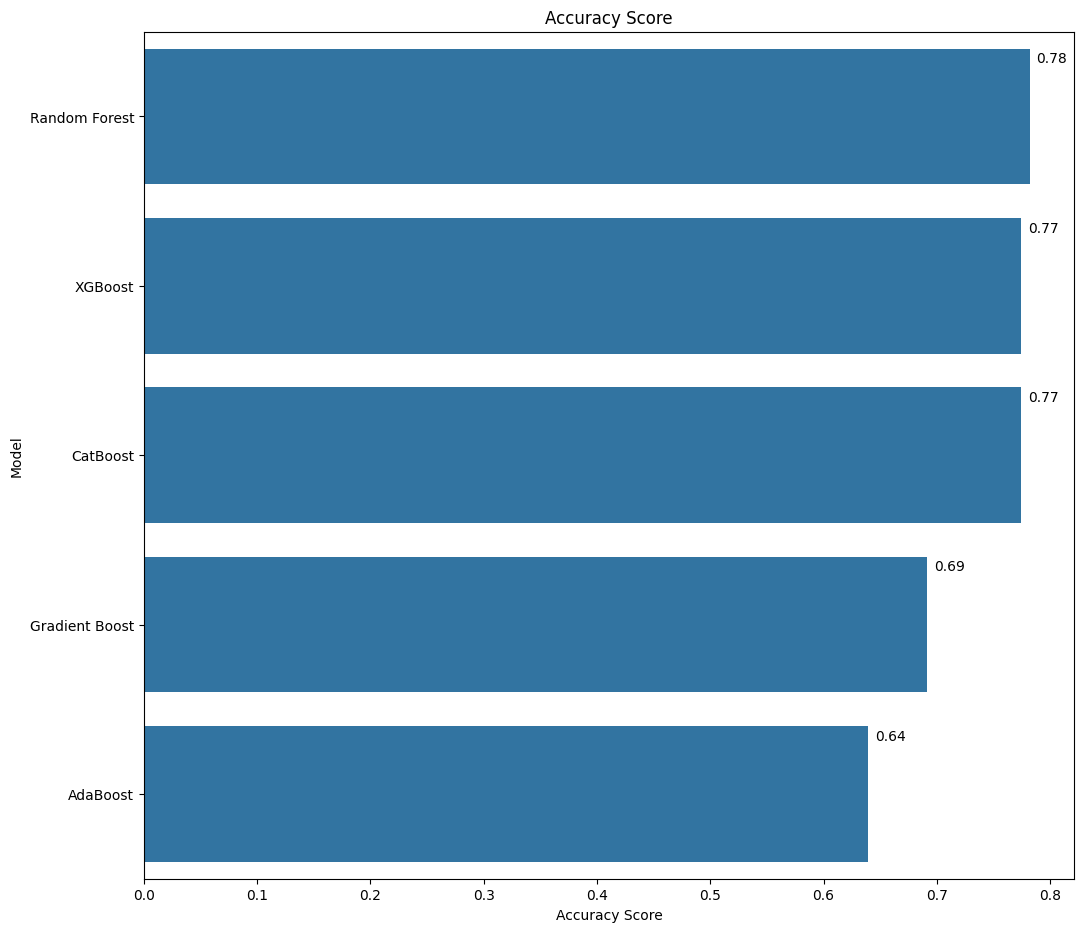

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the accuracy table
Accuracy_table = Store_model_results_over[["Model", "Accuracy Score"]].sort_values(by="Accuracy Score", ascending=False)

# Create the barplot
fig, ax = plt.subplots(figsize=(12, 11))
sns.barplot(y='Model', x='Accuracy Score', data=Accuracy_table, ax=ax).set(title="Accuracy Score")

# Add labels to the bars
for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}',
                ((p.get_x() + p.get_width()), p.get_y()),
                xytext=(5, -10),
                textcoords='offset points')

plt.show()

**Confusion Matrix**

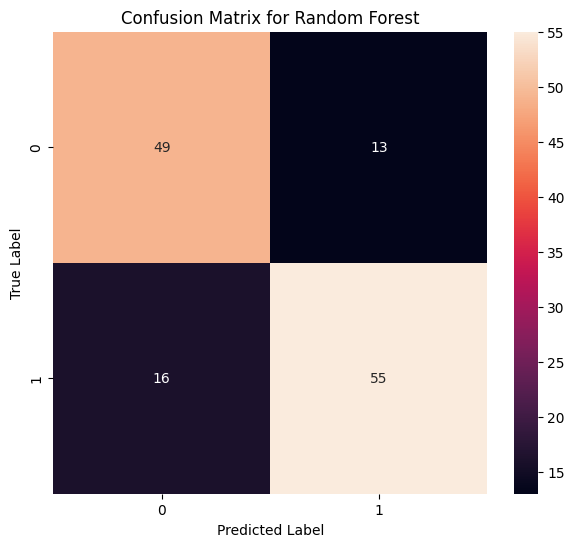

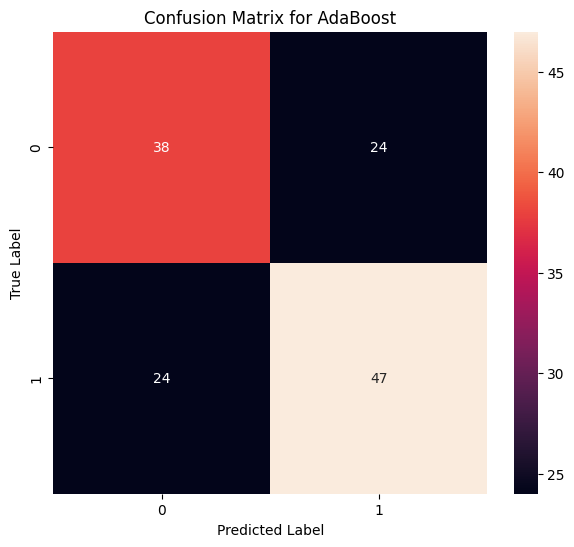

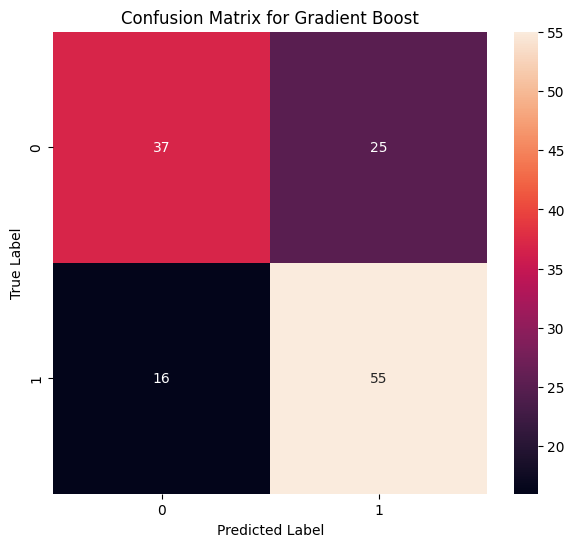

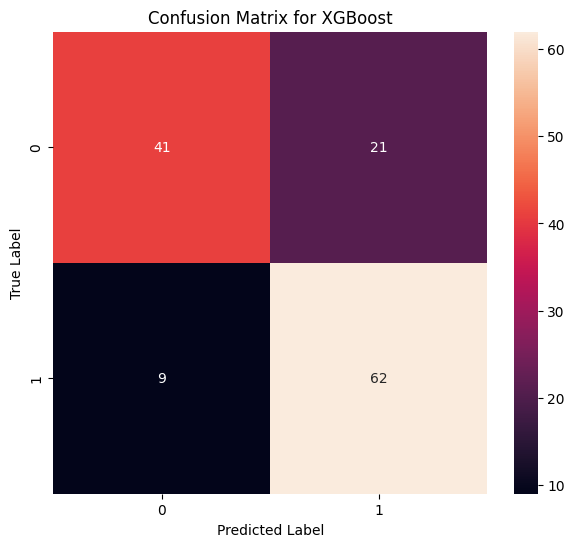

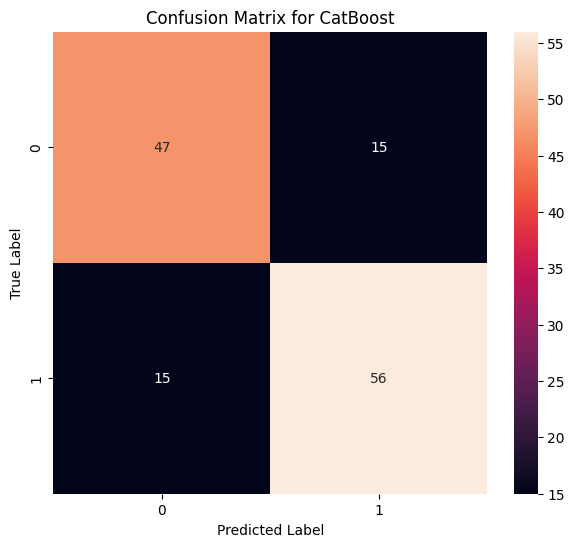

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

for model_name, model in Store_models_over:
    # Fit the model with your training data
    model.fit(X_train, y_train)

    # Make predictions on the test set
    predictions = model.predict(X_test)

    # Generate the confusion matrix
    cm = confusion_matrix(y_test, predictions)

    # Plot the confusion matrix using seaborn's heatmap
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f"Confusion Matrix for {model_name}")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.show()


True Negative - 118 (truely saying negative - non anemic cases correctly identified as non anemic)

True Postive - 15 (truely saying positive - anemic cases correctly identified as anemic)

False Negative - 12 ( falsely saying negative - anemic transaction incorrectly identified as non anemic)

False Positive - 3 ( falsely saying positive - non anemic transaction incorrectly identified as anemic)

In [ ]:
y_test_series = y_test.squeeze()  # Convert DataFrame to Series
# Get the value counts of the Series
value_counts = y_test_series.value_counts()
print(value_counts)


severe_maleria
1    71
0    62
Name: count, dtype: int64


**ROC Curve**

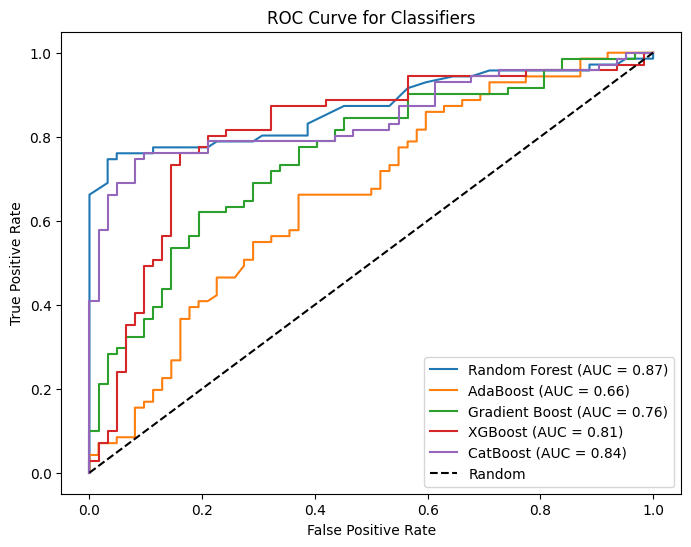

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Plot ROC curves for each classifier
plt.figure(figsize=(8, 6))

for clf_name, clf in Store_models_over:
    clf.fit(X_train, y_train)
    y_pred_prob = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f'{clf_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Classifiers')
plt.legend(loc='lower right')
plt.show()

# Feature Importance of the Top  Models using the MCC evaluation metrics

**Random Forest Classifier**

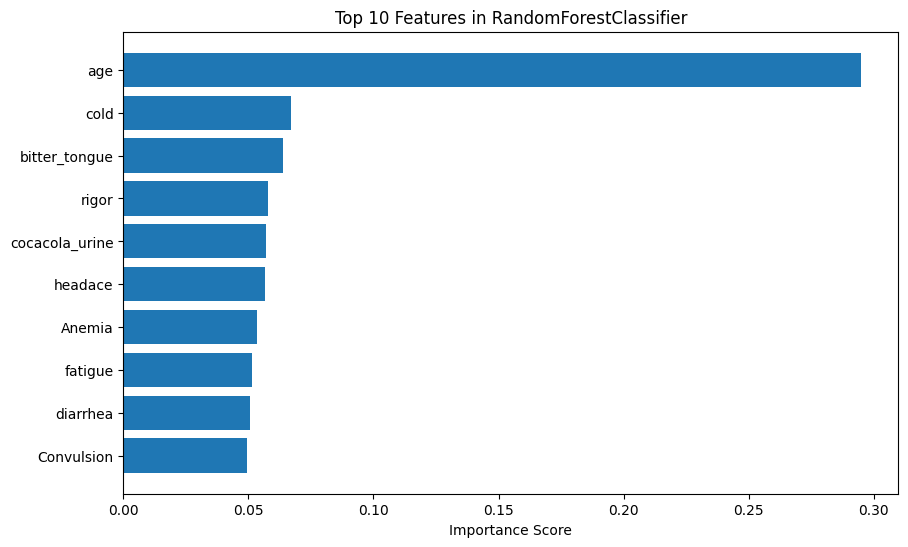

In [ ]:
# Initialize RandomForestClassifier
random_forest = RandomForestClassifier(random_state=123)

# Train the model
random_forest.fit(X_train, y_train)

# Get feature importances from the trained model
importances = random_forest.feature_importances_

# Get the indices of the top 10 features with the highest importance scores
indices = np.argsort(importances)[-10:]

# Plot the top 10 features with their importance scores in a bar chart
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Importance Score')
plt.title('Top 10 Features in RandomForestClassifier')
plt.show()


#CatBoost Classifier

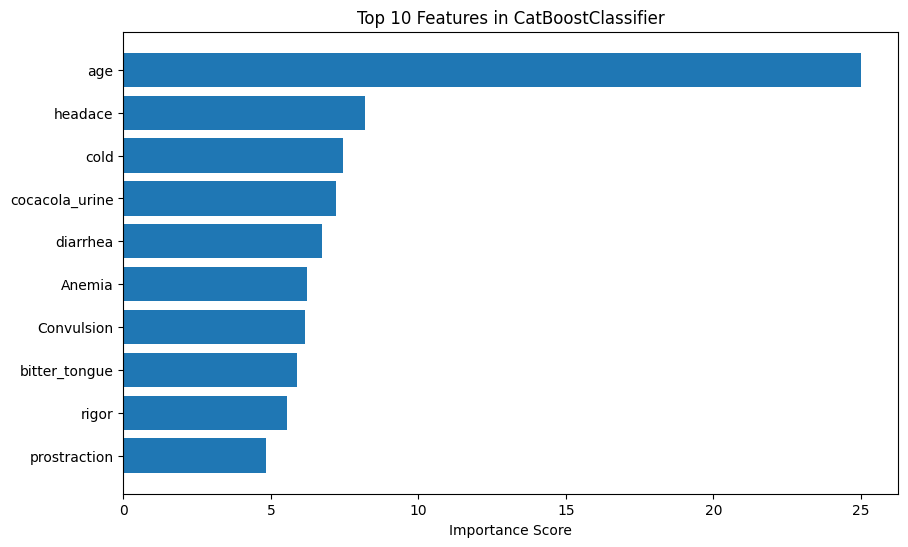

In [ ]:
# Initialize CatBoostClassifier
catboost = CatBoostClassifier(random_state=123, silent=True)

# Train the model
catboost.fit(X_train, y_train)

# Get feature importances from the trained model
importances = catboost.get_feature_importance()

# Get the indices of the top 10 features with the highest importance scores
indices = np.argsort(importances)[-10:]

# Plot the top 10 features with their importance scores in a bar chart
plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.xlabel('Importance Score')
plt.title('Top 10 Features in CatBoostClassifier')
plt.show()


# Plotting the Accuracy Scores

In [ ]:
Accuracy_table = Store_model_results_over[["Model","Accuracy Score"]].sort_values(by = "Accuracy Score", ascending = False)
Accuracy_table

Model  Accuracy Score
0   Random Forest        0.781955
3         XGBoost        0.774436
4        CatBoost        0.774436
2  Gradient Boost        0.691729
1        AdaBoost        0.639098

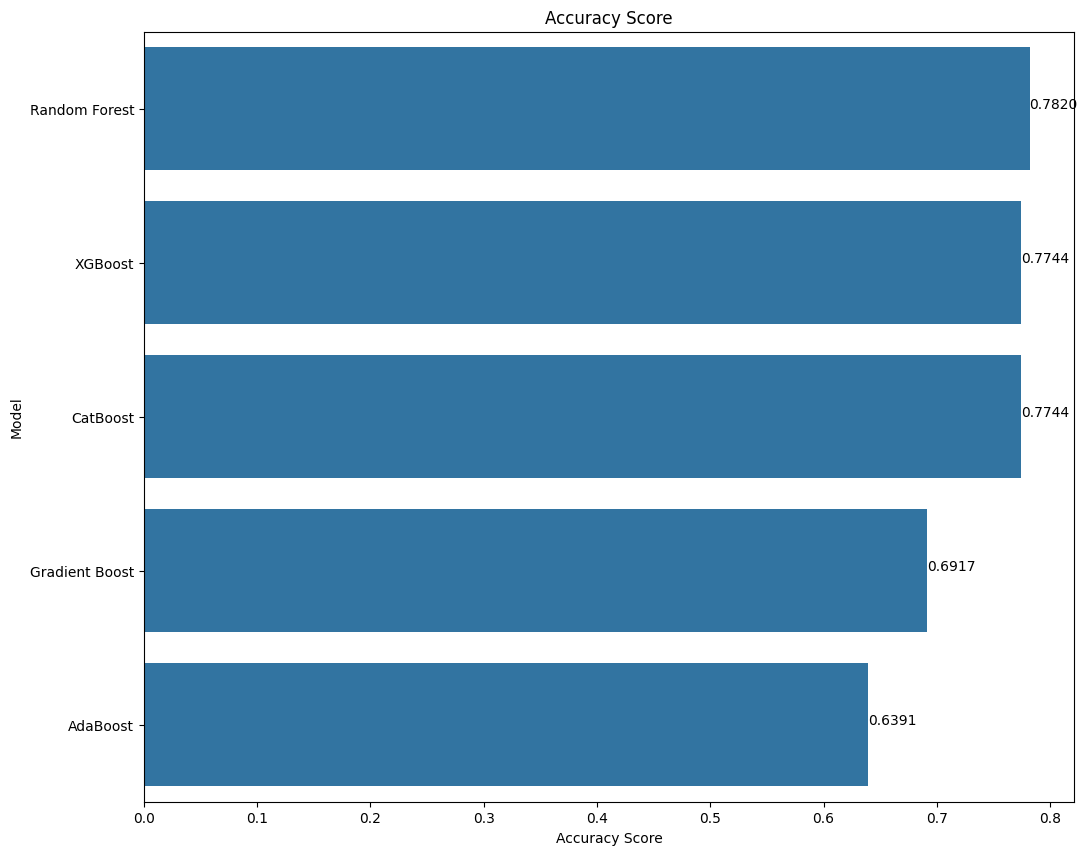

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))

# drawing the plot
sns.barplot(y='Model', x='Accuracy Score', data=Accuracy_table, ax=ax).set(title="Accuracy Score")

# Add labels to the bars
for i in ax.patches:
    ax.text(i.get_width(), i.get_y() + 0.5 * i.get_height(), f'{i.get_width():.4f}', fontsize=10, color='black')

plt.show()


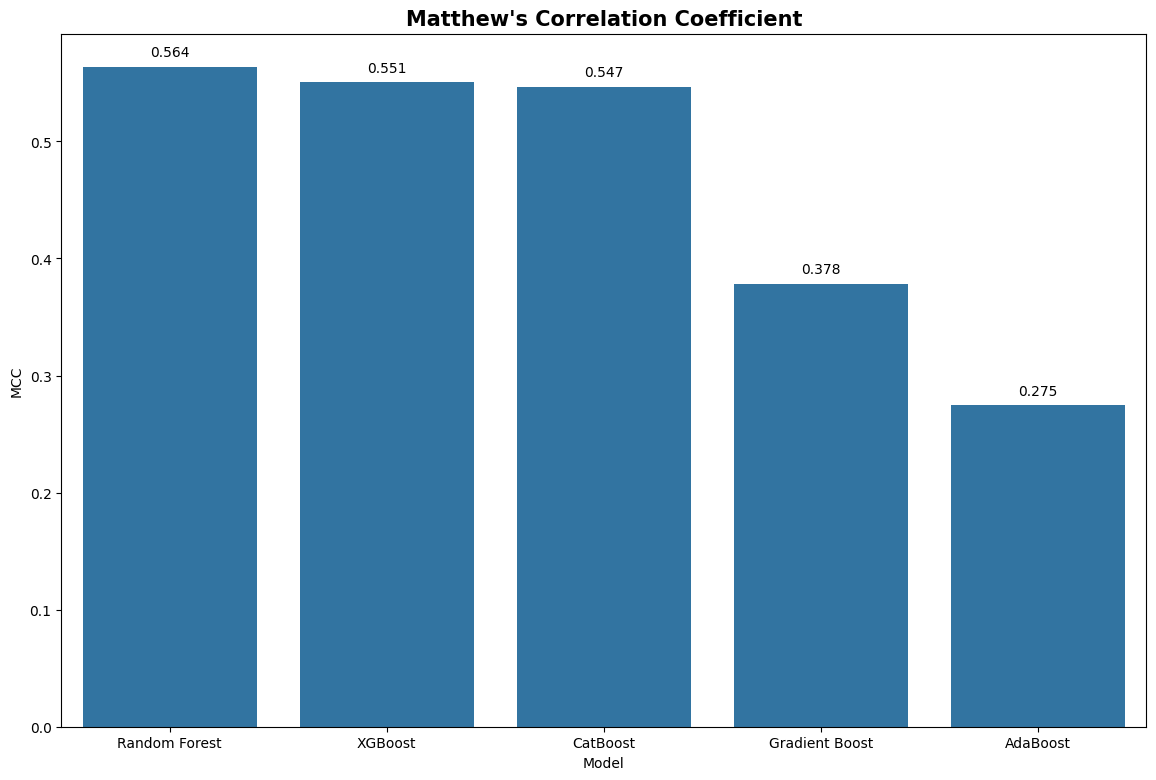

In [ ]:
MCC_table = Store_model_results_over[["Model", "MCC"]].sort_values(by="MCC", ascending=False)
fig, ax = plt.subplots(figsize=(14, 9))

# drawing the plot
sns.barplot(x='Model', y='MCC', data=MCC_table, ax=ax)
plt.title("Matthew's Correlation Coefficient", fontweight='bold', fontsize=15)

# Add labels to the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 10),
                   textcoords = 'offset points')

plt.show()


# LIME

**Random Forest explainer**

In [ ]:

instance_to_explain = X_test.iloc[0]

# Define your feature names with labels
feature_names_with_labels = list(X_train.columns)
feature_names_with_labels.append("Severe Malaria")

# Create a LIME explainer for tabular data with feature names including labels
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode="classification", feature_names=feature_names_with_labels, class_names=['No Malaria', 'Severe Malaria'])

# Explain the model's prediction for the chosen instance
explanation = explainer.explain_instance(instance_to_explain.values, random_forest.predict_proba, num_features=10)

# Display the explanation
explanation.show_in_notebook()


**CatBoost Explainer**

In [ ]:

instance_to_explain = X_test.iloc[0]

# Define your feature names with labels
feature_names_with_labels = list(X_train.columns)
feature_names_with_labels.append("Severe Malaria")

# Create a LIME explainer for tabular data with feature names including labels
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, mode="classification", feature_names=feature_names_with_labels, class_names=['No Malaria', 'Severe Malaria'])

# Explain the model's prediction for the chosen instance
explanation = explainer.explain_instance(instance_to_explain.values, catboost.predict_proba, num_features=10)

# Display the explanation
explanation.show_in_notebook()


# **Permutation Feature Importance**

**CatBoost PFI**


Permutation Feature Importances:
hypoglycemia: -0.0065
hyperpyrexia: -0.0021
Anemia: 0.0102
rigor: 0.0126
fatigue: 0.0150
fever: 0.0175
cold: 0.0304
vomitting: 0.0314
diarrhea: 0.0332
bitter_tongue: 0.0353
prostraction: 0.0429
cocacola_urine: 0.0430
headace: 0.0455
Convulsion: 0.0489
age: 0.1722


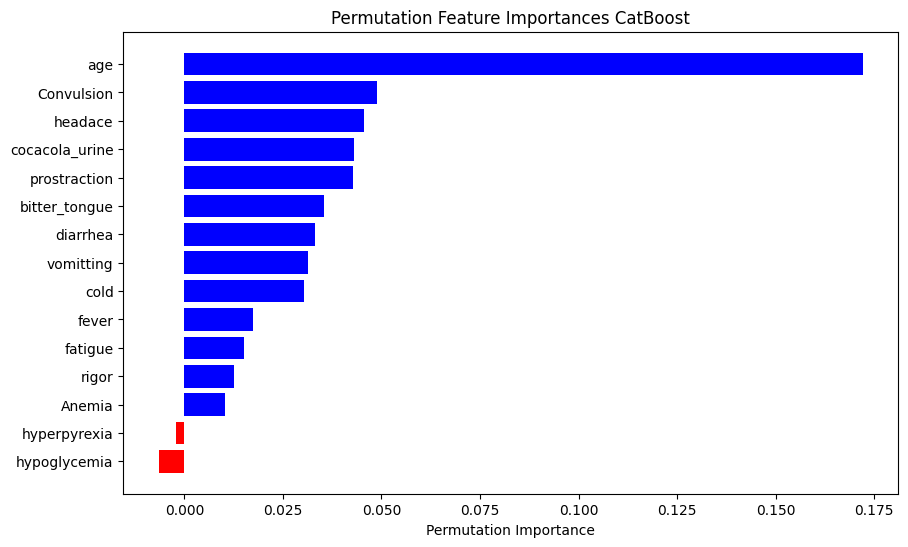

In [ ]:
clf = CatBoostClassifier(random_state=70)

# Train the model
clf.fit(X_train, y_train, verbose=False)
#clf.fit(X_train_resampled, y_train_resampled, verbose=False)



# Evaluate the model's accuracy on the test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
#print("Accuracy of the model:", accuracy)

# Function to calculate permutation feature importance
def permutation_importance(model, X, y, metric, num_iterations=100):
    baseline_score = metric(y, model.predict(X))
    importances = {}
    for col in X.columns:
        importance_scores = []
        for _ in range(num_iterations):
            X_permuted = X.copy()
            X_permuted[col] = np.random.permutation(X_permuted[col])
            permuted_score = metric(y, model.predict(X_permuted))
            #importance_scores.append(permuted_score - baseline_score)
            importance_scores.append(baseline_score - permuted_score)
        importances[col] = np.mean(importance_scores)
    return importances

# Calculate permutation feature importance
importances = permutation_importance(clf, X_test, y_test, accuracy_score)

# Sort feature importances
sorted_importances = {k: v for k, v in sorted(importances.items(), key=lambda item: item[1], reverse=False)}

# Print feature importances
print("\nPermutation Feature Importances:")
for feature, importance in sorted_importances.items():
    print(f"{feature}: {importance:.4f}")

# Plotting feature importances
plt.figure(figsize=(10, 6))

# Assigning colors based on values
colors = ['blue' if v >= 0 else 'red' for v in sorted_importances.values()]

plt.barh(range(len(sorted_importances)), list(sorted_importances.values()), color=colors, align='center')
plt.yticks(range(len(sorted_importances)), list(sorted_importances.keys()))
plt.xlabel('Permutation Importance')
plt.title('Permutation Feature Importances CatBoost')
plt.show()


**Random Forest PFI**


Permutation Feature Importances:
Anemia: -0.0004
hypoglycemia: 0.0032
fever: 0.0059
hyperpyrexia: 0.0073
prostraction: 0.0183
cold: 0.0197
fatigue: 0.0219
bitter_tongue: 0.0258
Convulsion: 0.0353
diarrhea: 0.0365
vomitting: 0.0374
cocacola_urine: 0.0382
rigor: 0.0411
headace: 0.0445
age: 0.1202


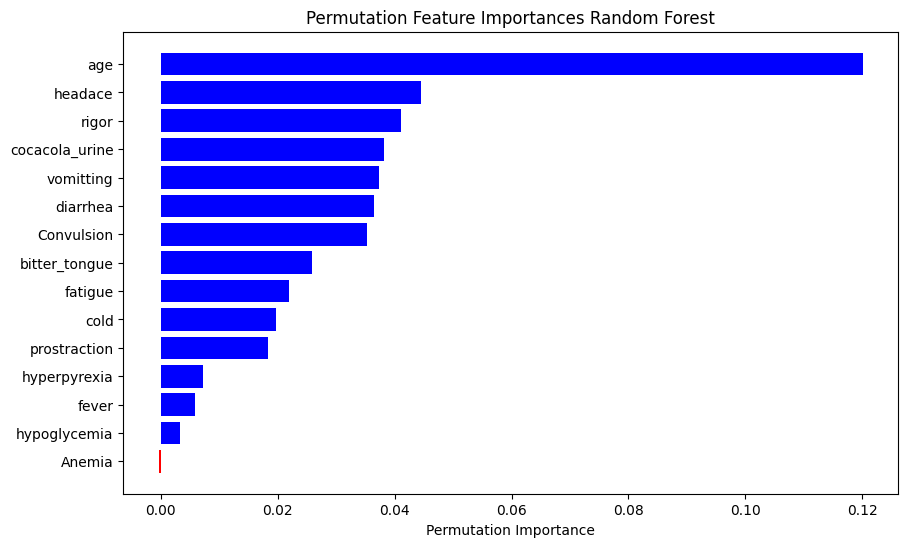

In [ ]:
#Train a random forest classifier
clf = RandomForestClassifier(random_state=120)
# clf.fit(X_train, y_train)


# Train the model
#clf.fit(X_train, y_train)
clf.fit(X_train, y_train)



# Evaluate the model's accuracy on the test set
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
#print("Accuracy of the model:", accuracy)

# Function to calculate permutation feature importance
def permutation_importance(model, X, y, metric, num_iterations=100):
    baseline_score = metric(y, model.predict(X))
    importances = {}
    for col in X.columns:
        importance_scores = []
        for _ in range(num_iterations):
            X_permuted = X.copy()
            X_permuted[col] = np.random.permutation(X_permuted[col])
            permuted_score = metric(y, model.predict(X_permuted))
            #importance_scores.append(permuted_score - baseline_score)
            importance_scores.append(baseline_score - permuted_score)
        importances[col] = np.mean(importance_scores)
    return importances

# Calculate permutation feature importance
importances = permutation_importance(clf, X_test, y_test, accuracy_score)

# Sort feature importances
sorted_importances = {k: v for k, v in sorted(importances.items(), key=lambda item: item[1], reverse=False)}

# Print feature importances
print("\nPermutation Feature Importances:")
for feature, importance in sorted_importances.items():
    print(f"{feature}: {importance:.4f}")

# Plotting feature importances
plt.figure(figsize=(10, 6))

# Assigning colors based on values
colors = ['blue' if v >= 0 else 'red' for v in sorted_importances.values()]

plt.barh(range(len(sorted_importances)), list(sorted_importances.values()), color=colors, align='center')
plt.yticks(range(len(sorted_importances)), list(sorted_importances.keys()))
plt.xlabel('Permutation Importance')
plt.title('Permutation Feature Importances Random Forest')
plt.show()
